# Curso NLP y DeepLearning
## Actividad 1: Procesamiento de texto
### Damián A. Fernández
### CoderHouse - Comisión 60900 (2024)

# Descripción de proyecto
Este proyecto se trata de una práctica integradora del módulo NLP del curso "DataScience III: NLP y Deep Learning"


### Hipótesis
Verificar la posibilidad de detectar el sentimiento subyacente de los mensajes, inicialemente de forma polarizada (positivo o negativo).


### Objetivos
#### General
- Elaborar un modelo analizador de sentimiento de forma polarizada (positivo/negativo) a partir de un dataset de tweets en español etiquetados por emoción y sentimientos específicos

#### Específicos
- Análisis exploratorio de los datos, incluyendo análisis con herramientas de NLP
- Limpieza de datos
- Selección de features y variable target
- Procesamiento NLP (tokenización, estandarización, lematización, entre otros)
- Desarrollo de un modelo inicial de análisis de sentimiento utilizando regresión logística

### Descripción de dataset

Se trabajará con un dataset de tweets en español disponible en kaggle.com.
Incluye, además del usuario, texto del tweet y horario, un etiquetado de emoción y de sentimiento específicos.
Fuente: https://www.kaggle.com/datasets/philipsanm/sentiment-analysis-in-spanish-tweets

# Lectura de datos

### Librerias necesarias

In [1]:
!python -m spacy download es_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 8.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import random
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from babel.numbers import format_decimal
from collections import Counter

import spacy
import es_core_news_md
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams
from wordcloud import WordCloud

### Definición de funciones útiles

In [3]:
def format_num(num: float) -> str:
    """ Función para formatear números con separador de miles (.) y decimales (,) para mejor visualización
    """
    return format_decimal(num, locale='es_ES')

### Lectura del corpus

In [4]:
file = 'https://raw.githubusercontent.com/damianmdp/ch_nlp_act1/main/sentiment_analysis_spa_dataset.csv'
df = pd.read_csv(file)

# Análisis Exploratorio

In [5]:
df.sample(10)

,user,text,date,emotion,sentiment
2113,@esasOtra,Baltasar me cago en mi bida edition,"Jan 5, 2024 · 9:38 PM UTC",surprised,powerful
2379,@tatianasm06,"Por la película dije ""Nando Parrado tiene que ...","Jan 6, 2024 · 2:10 AM UTC",optimistic,joyful
2273,@padia_22,el loco bromista se esta apagando poco a poco...,"Jan 5, 2024 · 12:02 PM UTC",playful,joyful
2530,@Witch_Susan23,Olvidarte nene se volvió una osadía,"Jan 6, 2024 · 3:08 AM UTC",daring,joyful
1393,@oceano_m,Sustos que no dan gusto 🫨,"Jan 6, 2024 · 3:05 AM UTC",relaxed,peaceful
1876,@SerEnDesarrollo,10 habilidades que te pagarán para toda la vid...,"Jan 3, 2024 · 9:00 PM UTC",confident,powerful
1182,@rinconmondongo,Ya se reactivó el grupo de la universidad dand...,"Jan 5, 2024 · 8:59 PM UTC",responsive,peaceful
1744,@Sammarrod,Un aplauso a mi señor novio por haber resuelto...,"Jan 6, 2024 · 2:31 AM UTC",secure,peaceful
2315,@CheckmateBreaks,Que naciera a las 4:20 de la madrugada tendrá ...,"Dec 3, 2023 · 9:54 PM UTC",playful,joyful
1879,@JulietaNunez21_,El amor propio y la autoconfianza te salvan d ...,"Jan 2, 2024 · 2:42 AM UTC",confident,powerful


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590 entries, 0 to 2589
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user       2590 non-null   object
 1   text       2590 non-null   object
 2   date       2590 non-null   object
 3   emotion    2590 non-null   object
 4   sentiment  2590 non-null   object
dtypes: object(5)
memory usage: 101.3+ KB


In [7]:
df.describe()

,user,text,date,emotion,sentiment
count,2590,2590,2590,2590,2590
unique,2083,2191,949,20,6
top,@Yaramsi3,"Para entender el mundo, lee. Para entenderte ...","Jan 6, 2024 · 3:38 AM UTC",sleepy,peaceful
freq,12,6,25,150,660


*Observación: existen tweets duplicados*

#### Remoción de tweets duplicados

In [9]:
df.drop_duplicates(subset=['text'], inplace=True)
df.shape

(2191, 5)

### Análisis de potencial variable target

In [10]:
df['emotion'].value_counts()

emotion
jealous        140
successful     134
overwhelmed    130
sleepy         130
distant        129
irritated      128
surprised      127
loving         121
playful        120
secure         120
confident      116
thankful       110
relaxed        110
responsive     103
embarrassed    101
optimistic      83
stupid          80
daring          76
frustrated      73
isolated        60
Name: count, dtype: int64

<ipython-input-13-8ab12beee2b3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='emotion', data=df, palette='Set2')


<Axes: xlabel='emotion', ylabel='count'>

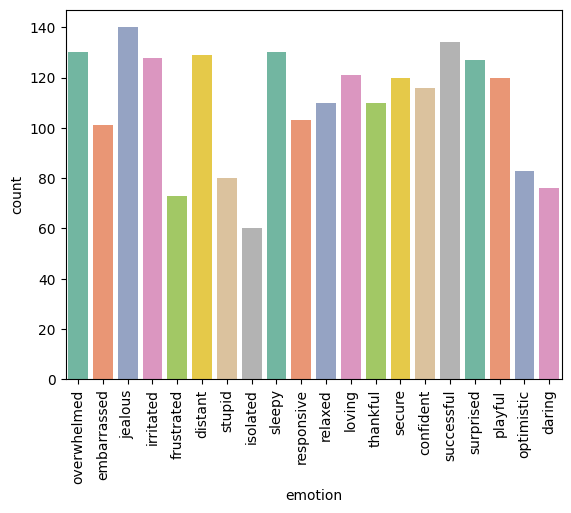

In [13]:
plt.xticks(rotation=90)
sns.countplot(x='emotion', data=df, palette='Set2')

In [14]:
df['sentiment'].value_counts()

sentiment
peaceful    564
mad         470
powerful    377
joyful      279
sad         270
scared      231
Name: count, dtype: int64

<ipython-input-16-4b69ef77ca5e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='Set2')


<Axes: xlabel='sentiment', ylabel='count'>

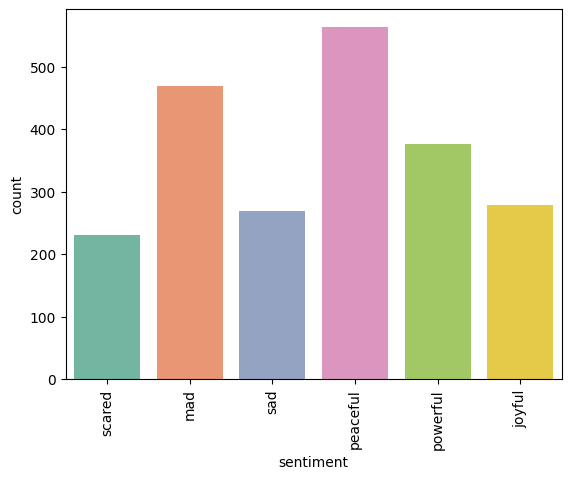

In [16]:
plt.xticks(rotation=90)
sns.countplot(x='sentiment', data=df, palette='Set2')

### Análisis de potencial agrupamiento polarizado

In [17]:
POSITIVE_SENTIMENTS = ['peaceful', 'powerful', 'joyful']
NEGATIVE_SENTIMENTS = ['scared', 'mad', 'sad']

res = df['sentiment'].map(lambda x: True if x in POSITIVE_SENTIMENTS else False).sum()
res_percent = np.round((res / df.shape[0]) * 100, 1)
print(f'Representatividad de sentimientos positivos: {format_num(res)} ({format_num(res_percent)}%)')
res = df['sentiment'].map(lambda x: True if x in NEGATIVE_SENTIMENTS else False).sum()
res_percent = np.round((res / df.shape[0]) * 100, 1)
print(f'Representatividad de sentimientos negativos: {format_num(res)} ({format_num(res_percent)}%)')

Representatividad de sentimientos positivos: 1.220 (55,7%)
Representatividad de sentimientos negativos: 971 (44,3%)


### Análisis de diversidad de usuarios

In [18]:
df['user'].value_counts()

user
@Exasperante__      8
@Yaramsi3           7
@Ax8XF              6
@lobitogus          6
@joselinconjota     6
                   ..
@JugadaSeguraVip    1
@ceciliadelcid12    1
@Daanniiss17        1
@morningstars_1     1
@brigethcoba        1
Name: count, Length: 2072, dtype: int64

In [19]:
res = df['user'].value_counts().shape[0]
print(f'Cantidad de usuarios: {format_num(res)}')

Cantidad de usuarios: 2.072


In [20]:
res = df['user'].value_counts().map(lambda x: True if x == 1 else False).sum()
print(f'Cantidad de usuarios con un único tweet: {format_num(res)}')

Cantidad de usuarios con un único tweet: 2.000


In [21]:
res = (df['user'].value_counts().max() / df.shape[0]) * 100
print(f'Representatividad de usuario con mayor cantidad de tweets: {format_num(res)}%')

Representatividad de usuario con mayor cantidad de tweets: 0,365%


### Visualización de tweets

In [22]:
all_tweets = df['text'].to_list()

res = random.sample(all_tweets, 10)
print("Ejemplos de tweets:")
for x in res: print(f'- {x}')

Ejemplos de tweets:
- "Lo que más miedo me da, es ver cómo desapareces de este mundo, es a lo que más temo, un mundo sin ti…"
- Despreocupado porque nadie se a visto que me diga las cosas en la cara
- El cínico-la teoría- llama a las cosas por su nombre! Desvergonzado- uso general- como sea, me gusta y aplico la primera. López gastando lo que no es de él, y promoviendo su magnanimidad” ante los P… ! Tomen pues lo que les den pero voten por Xóchitl que será auténtica!!!😉
- Volvieron los turnos de calidad de Oswaldo Arcia.  Lo más positivo a nivel ofensivo. Siempre en mi equipo esta bestia.
- Nah mks, necesito un tremendo abrazo. Estoy que me caigo por saudade.
- Mejor me fue cuando cultive una mente imperturbable frente a las adversidades.
- anonadado.
- lo amodorrado que estoy hoy
- Estoy impactado viendo el stream de @elxocas viendo todo lo que se esta destapando con los pedrastras🤯🤯
- mis ojos en lo alto de la escala de Mohs, y dentro de los suyos atrapado todo el cosmos...


## Análisis exploratorio con NLP

In [23]:
res = len(all_tweets)
print(f'Cantidad de Tweets: {format_num(res)}')

Cantidad de Tweets: 2.191


In [24]:
tweets_len = list(map(len, all_tweets))
print('Análisis estadístico de longitud de tweets:')
pd.Series(tweets_len).describe()

Análisis estadístico de longitud de tweets:


count    2191.000000
mean      133.856686
std       118.149733
min         6.000000
25%        61.000000
50%       108.000000
75%       201.000000
max      3845.000000
dtype: float64

<ipython-input-27-81a7afb142c1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=tweets_len, orient='h', palette='Set1')


Text(0, 0.5, 'Número de caracteres')

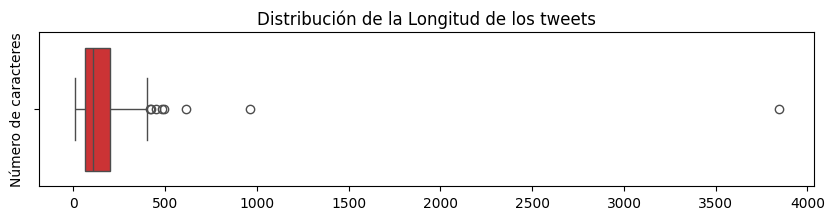

In [27]:
plt.figure(figsize=(10,2))
sns.boxplot(data=tweets_len, orient='h', palette='Set1')
plt.title('Distribución de la Longitud de los tweets')
plt.ylabel('Número de caracteres')

In [28]:
q1_len, q3_len = np.quantile(tweets_len, [.25, .75])
iqr_len = q3_len - q1_len
outlier_high_limit_len = q3_len + (3 * iqr_len)
outlier_high_limit_len

621.0

In [29]:
df[df['text'].map(len)>(outlier_high_limit_len)]

,user,text,date,emotion,sentiment
560,@luiscostabonino,"El Presidente, con su estrategia política pers...","Jan 5, 2024 · 7:21 PM UTC",frustrated,mad
2152,@ramonfonsecamor,💥 ÚLTIMAS NOTICIAS: ¡Revelaciones explosivas s...,"Jan 5, 2024 · 8:44 PM UTC",surprised,powerful


*Observación: existen pocos tweets extremadamente largos*

Text(0, 0.5, 'Cantidad de tweets')

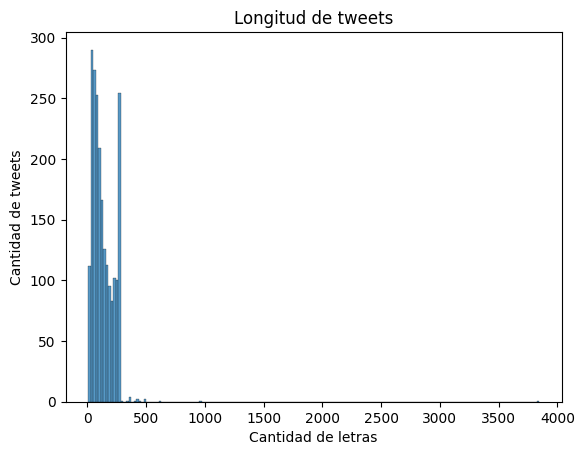

In [62]:
sns.histplot(data=tweets_len)
plt.title('Longitud de tweets')
plt.xlabel('Cantidad de letras')
plt.ylabel('Cantidad de tweets')

### Procesamiento de texto con spaCy


In [31]:
corpus_joined = '. '.join(all_tweets)

In [32]:
nlp = es_core_news_md.load()
doc = nlp(corpus_joined)

#### Análisis de Oraciones

In [33]:
all_sentences = list(doc.sents)

res = random.sample(all_sentences, 10)
print("Ejemplos de oraciones:")
for x in res: print(f'- {x}')

Ejemplos de oraciones:
- 🥰.
- MiguelHernández.
- Todavía no lo entrego y yo creo que ya será hasta después del fin de semana que lo haga.   
- Hemos perdido haciendo 7 más de valoración que PAO, con 7 faltas recibidas menos y 14 TL menos.
- Gente corruptible, gente incorruptible.
- Entre en el body talla XS que me regaló E. El día en que te preocupes por ser mente rica, el dinero va a empezar a llegar por todos lados y te vas a dar cuenta de que lo más importantes es ser próspero, ser millonario en todo.
- ÚLTIMA HORA: se rumorea que el Aeropuerto de Gran Canaria quiere incorporar a Gündogan a su lista de aviones tras su asombroso despegue en el partido entre la UD y el Barça..
- Mi hermana una vez me juró, que a las niñas les gusta más, el más risueño y no el más guapetón..
- estoy desbordado.
- El mío como enredado, pero algo se hace..


In [34]:
res = len(all_sentences)
print(f'Cantidad de Oraciones: {format_num(res)}')

Cantidad de Oraciones: 3.646


In [35]:
sentences_len = list(map(len, all_sentences))
print('Análisis estadístico de longitud de oraciones:')
pd.Series(sentences_len).describe()

Análisis estadístico de longitud de oraciones:


count    3646.000000
mean       16.731761
std        12.298010
min         1.000000
25%         8.000000
50%        14.000000
75%        22.000000
max       104.000000
dtype: float64

Text(0, 0.5, 'Cantidad de oraciones')

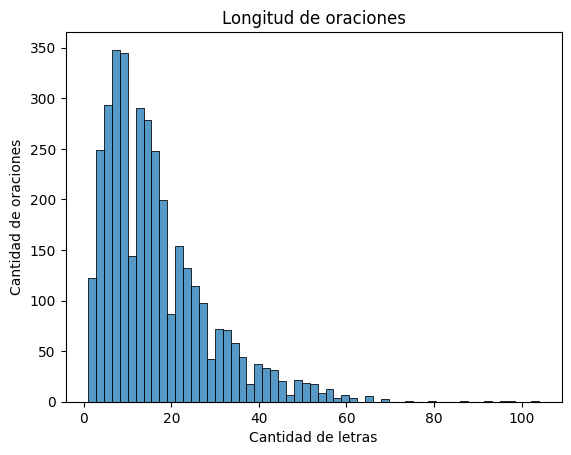

In [60]:
sns.histplot(data=sentences_len)
plt.title('Longitud de oraciones')
plt.xlabel('Cantidad de letras')
plt.ylabel('Cantidad de oraciones')

#### Análisis de Cantidad de Palabras

In [37]:
print('Primeros 10 tokens: ')
for x in doc[0:10]: print(f'- {x}')

Primeros 10 tokens: 
- termine
- bien
- abrumado
- después
- de
- hoy
- .
- me
- siento
- abrumado


In [38]:
res = len(doc)
print(f'Cantidad de tokens: {format_num(res)}')

Cantidad de tokens: 61.004


#### Análisis de Palabras sin Stopwords ni signos de puntuación

In [39]:
# Remoción de stopwords y signos de puntuación identificados por spaCy
words_clean = [token.text_with_ws for token in doc if not token.is_stop and not token.is_punct]

# Remoción de mayúsculas, espacios al inicio/final y tokens exclusivamente de espacios
words_clean = [w.strip().lower() for w in words_clean if not w.strip() == '']

In [40]:
res = len(words_clean)
print(f'Cantidad de tokens sin contar stopwords: {format_num(res)}')

Cantidad de tokens sin contar stopwords: 23.789


In [41]:
print('Primeros 10 tokens: ')
for x in words_clean[0:10]: print(f'- {x}')

Primeros 10 tokens: 
- termine
- abrumado
- siento
- abrumado
- siento
- abrumado
- cantidad
- cosas
- quiero
- dibujar


#### Análisis de la Frecuencia de Palabras

In [42]:
word_freq = Counter(words_clean)

In [43]:
print(f'Lista de 10 palabras más comunes:')
for x in word_freq.most_common(10): print(f'- {x}')

Lista de 10 palabras más comunes:
- ('q', 138)
- ('vida', 125)
- ('gente', 84)
- ('año', 74)
- ('quiero', 68)
- ('😭', 65)
- ('dios', 61)
- ('mundo', 59)
- ('siento', 58)
- ('cosas', 57)


In [44]:
unique_words = [w for (w, freq) in word_freq.items() if freq ==1]
res = len(unique_words)
print(f'Cantidad de palabras únicas: {format_num(res)}')

Cantidad de palabras únicas: 7.128


In [45]:
res = random.sample(unique_words, 20)
print("Ejemplos de palabras únicas:")
for x in res: print(f'- {x}')

Ejemplos de palabras únicas:
- exceso
- veremos
- qr
- ganar
- edadismo
- refresque
- disfrute
- adepto
- azúcar
- recibiendo
- batería
- tas
- 🩷🩷🩷.
- denunciado
- seguimos
- examenes
- eventualmente
- besa
- yuri
- sobrevivientes


*Observación: existen palabras que en realidad son etiquetas de nombres de usuarios*

In [48]:
user_names = [w for w in words_clean if w.startswith('@')]
' '.join(user_names)

'@franciamarquezm @dilianfrancisca @lafmcali @elpaiscali @mabellaranews @eltiempo @sergio_fajardo @minambienteco @parquescolombia @caracolradio @gobvalle @enteratecali @noti90minutos @mabellaranews @claraluzroldan @blupacifico @hotelmaguipi @petrogustavo @mpguatemala @pdhgt @drgiammattei @luisbnava @latam_chi @lambofyah @riverplate @euricsanti @granhermanoar @granhermanoac @jmilei @woshingo @correos @correosatiende @blazersargento @petrogustavo @_somosmadrid @jlmendoza @jmena26 @tiendasoriana @orgsoriana @biobio @radiocarab @ttisantiago @mop_chile @mop_rm @dezurdateam @franklportal @marianacuba71 @manolorgomez @gabyisla89 @pedritorojo83 @katibaez22 @avelazquezdiaz @almaguerlemus @cecics14 @betzabeglezp. @record_mexico @ansopas117 @guajirabikechallenge @petrogustavo @alejandrochar @petrogustavo @nestormoralesc @vickydavilah @darcyquinnr @gusgomez1701 @whatsapp @telegram @lopezobrador @2011rafaelhomez @libertypr @danteauthor @jorgebrito @biobio @radiocarab @ttisantiago @mop_chile @mop_rm

#### Eliminación de nombres de usuarios en campo *text*

In [49]:
words_clean = [w for w in words_clean if not w.startswith('@')]

#### Análisis de la Distribución de Longitud de Palabras

In [50]:
words_len = list(map(len, words_clean))
print('Análisis estadístico de longitud de palabras:')
pd.Series(words_len).describe()

Análisis estadístico de longitud de palabras:


count    23609.000000
mean         6.452920
std          3.122173
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max        100.000000
dtype: float64

<ipython-input-51-6307c314cc43>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=words_len, orient='h', palette='Set1')


Text(0, 0.5, 'Número de caracteres')

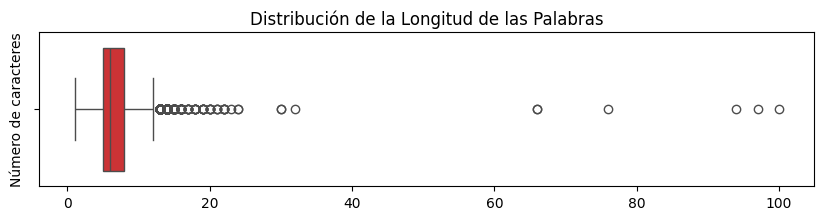

In [51]:
plt.figure(figsize=(10,2))
sns.boxplot(data=words_len, orient='h', palette='Set1')
plt.title('Distribución de la Longitud de las Palabras')
plt.ylabel('Número de caracteres')

*Observación: existen palabras inusualmente largas, que probablemente sean URLs*

#### Eliminación de URLs en campo *text*

In [52]:
words_clean = [w for w in words_clean if not (w.startswith('http') or w.startswith('https') or w.startswith('www'))]

In [53]:
words_len = list(map(len, words_clean))
print('Análisis estadístico de longitud de palabras:')
pd.Series(words_len).describe()

Análisis estadístico de longitud de palabras:


count    23602.000000
mean         6.432718
std          2.861902
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max         32.000000
dtype: float64

<ipython-input-55-6307c314cc43>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=words_len, orient='h', palette='Set1')


Text(0, 0.5, 'Número de caracteres')

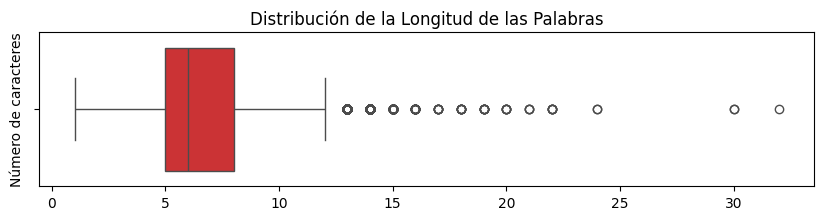

In [55]:
plt.figure(figsize=(10,2))
sns.boxplot(data=words_len, orient='h', palette='Set1')
plt.title('Distribución de la Longitud de las Palabras')
plt.ylabel('Número de caracteres')

In [56]:
words_lenghts = [(w, len(w)) for w in words_clean]
df_words_lenghts = pd.DataFrame(data=words_lenghts, columns=['Palabra', 'Longitud'])

In [57]:
df_words_lenghts.sort_values(by='Longitud', ascending=False)

,Palabra,Longitud
16799,"revolucionario"".#fidelporsiempre",32
16491,legisladoresfrenenaldictadorya,30
16505,legisladoresfrenenaldictadorya,30
2217,aquamanandthelostkingdom,24
6872,𝐏͟𝐫͟𝐞͟𝐫͟𝐫͟𝐞͟𝐬͟𝐞͟𝐫͟𝐯͟𝐚͟𝐬.,24
...,...,...
8006,q,1
7986,🤔,1
7982,◉,1
7980,○,1


*Observación: existen tokens conformados por concatenaciones de palabras sin espacios o con símbolos como separadores, así como caracteres únicos y emojis.*

#### Distribución de la Frecuencia de Palabras

Número de palabras únicas en el corpus: 10387


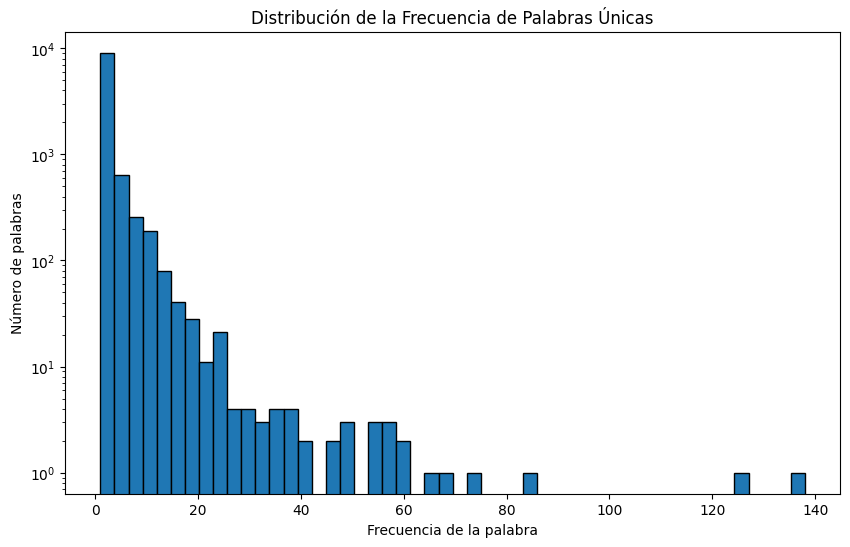

In [58]:
# Número de palabras únicas
words_set = set(words_clean)
print(f"Número de palabras únicas en el corpus: {len(words_set)}")

# Distribución de frecuencia de palabras únicas
unique_word_freq = [word_freq[word] for word in words_set]

plt.figure(figsize=(10, 6))
plt.hist(unique_word_freq, bins=50, edgecolor='black')
plt.title('Distribución de la Frecuencia de Palabras Únicas')
plt.xlabel('Frecuencia de la palabra')
plt.ylabel('Número de palabras')
plt.yscale('log')  # Escala logarítmica para mejor visualización
plt.show()

### Análisis de las Partes del Discurso (POS-Tagging)

***Este análisis se está realizando con el corpus sin limpieza de stopwords, etc***

In [63]:
nouns_list = []
adjectives_list = []
verbs_list = []

for token in doc:
    if token.pos_ == 'NOUN':
        nouns_list.append(token.text)
    if token.pos_ == 'ADJ':
        adjectives_list.append(token.text)
    if token.pos_ == 'VERB':
        verbs_list.append(token.text)

print(' - Ejemplos de sustantivos encontrados:')
print(random.sample(nouns_list, 20))
print('\n - Ejemplos de adjetivos encontrados:')
print(random.sample(adjectives_list, 20))
print('\n - Ejemplos de verbos encontrados:')
print(random.sample(verbs_list, 20))

 - Ejemplos de sustantivos encontrados:
['vez', 'aún-', 'edad', 'pena', 'máquinas', '🙏', 'suegra', 'autoconfianza', 'interés', 'persona', 'diversidad', 'odio', 'sectores', 'amor', 'cintura', 'codo', 'veces', 'soltero', 'medio', 'migrantes']

 - Ejemplos de adjetivos encontrados:
['incomodo', 'responsable', 'libre', 'seguro', 'intensivo', 'laboral', 'valiente', 'despierto', 'magos', 'tranquilo', 'menores', 'competitivo', 'mortificado', 'mexicano', 'enojado', 'dulce', 'drogado', 'triste', 'eléctrico', 'retrasados']

 - Ejemplos de verbos encontrados:
['recordaré', 'sentirme', 'decir', 'vi', 'lleva', 'escuchar', 'Pensé', 'vieran', 'limosnear', 'pidió', 'emitió', 'pereceré', 've', 'reducir', 'siento', 'cuesta', 'Estoy', 'necesitaba', 'soportaste', 'visto']


#### Sustantivos más frecuentes (primeros 10)

In [64]:
Counter(nouns_list).most_common(10)

[('vida', 122),
 ('día', 87),
 ('gente', 74),
 ('año', 71),
 ('vez', 65),
 ('días', 55),
 ('mundo', 55),
 ('tiempo', 55),
 ('cosas', 52),
 ('amor', 49)]

#### Adjetivos más frecuentes (primeros 10)

In [65]:
Counter(adjectives_list).most_common(10)

[('mejor', 46),
 ('rápido', 35),
 ('bueno', 35),
 ('nuevo', 33),
 ('❤', 29),
 ('cansado', 26),
 ('solo', 25),
 ('gran', 21),
 ('feliz', 21),
 ('buena', 19)]

#### Verbos más frecuentes (primeros 10)

In [66]:
Counter(verbs_list).most_common(10)

[('hacer', 84),
 ('ver', 76),
 ('tengo', 69),
 ('hace', 60),
 ('tiene', 60),
 ('siento', 55),
 ('quiero', 52),
 ('😭', 52),
 ('tener', 46),
 ('da', 41)]

### Análisis de N-gramas

#### Bigramas más frecuentes (primeros 10)

In [67]:
bigrams = ngrams(words_clean, 2)
Counter(bigrams).most_common(10)

[(('🥺', '🥺'), 41),
 (('😭', '😭'), 32),
 (('unidostodosx', 'dezurdateam'), 16),
 (('carlos', 'bremer'), 15),
 (('⠀', '⠀'), 15),
 (('❤', '️'), 12),
 (('⚽', '⚽'), 12),
 (('─', '─'), 10),
 (('❤', '️.'), 10),
 (('reyes', 'magos'), 9)]

#### Trigramas más frecuentes (primeros 10)

In [68]:
trigrams = ngrams(words_clean, 3)
Counter(trigrams).most_common(10)

[(('🥺', '🥺', '🥺'), 39),
 (('😭', '😭', '😭'), 17),
 (('⚽', '⚽', '⚽'), 11),
 (('⠀', '⠀', '⠀'), 7),
 (('❓', '❓', '❓'), 7),
 (('︎', '︎', '︎'), 6),
 (('🕯', '️', '🕯'), 5),
 (('😵', '\u200d', '💫'), 5),
 (('🤣', '🤣', '🤣'), 5),
 (('odia', 'rebaño', 'piensa'), 5)]

*Observación: La concatenación de emojis con espacios entremedio afecta a la detección de n-gramas comunes*

#### Tetragramas más frecuentes (primeros 10)

In [69]:
tetragrams = ngrams(words_clean, 4)
Counter(tetragrams).most_common(10)

[(('🥺', '🥺', '🥺', '🥺'), 37),
 (('⚽', '⚽', '⚽', '⚽'), 10),
 (('😭', '😭', '😭', '😭'), 7),
 (('❓', '❓', '❓', '❓'), 6),
 (('︎', '︎', '︎', '︎'), 5),
 (('odia', 'rebaño', 'piensa', 'distinto'), 5),
 (('rebaño', 'piensa', 'distinto', 'opinión'), 5),
 (('piensa', 'distinto', 'opinión', 'osadía'), 5),
 (('distinto', 'opinión', 'osadía', 'querer'), 5),
 (('opinión', 'osadía', 'querer', 'pensar'), 5)]

#### Pentagramas más frecuentes (primeros 10)

In [70]:
pentagrams = ngrams(words_clean, 5)
Counter(pentagrams).most_common(10)

[(('🥺', '🥺', '🥺', '🥺', '🥺'), 36),
 (('⚽', '⚽', '⚽', '⚽', '⚽'), 9),
 (('❓', '❓', '❓', '❓', '❓'), 5),
 (('odia', 'rebaño', 'piensa', 'distinto', 'opinión'), 5),
 (('rebaño', 'piensa', 'distinto', 'opinión', 'osadía'), 5),
 (('piensa', 'distinto', 'opinión', 'osadía', 'querer'), 5),
 (('distinto', 'opinión', 'osadía', 'querer', 'pensar'), 5),
 (('︎', '︎', '︎', '︎', '︎'), 4),
 (('🕯', '️', '🕯', '️', '🕯'), 3),
 (('soledad', 'peligrosa', 'adictiva', 'convierte', 'hábito'), 3)]

#### Hexagramas más frecuentes (primeros 10)

In [71]:
hexagrams = ngrams(words_clean, 6)
Counter(hexagrams).most_common(10)

[(('🥺', '🥺', '🥺', '🥺', '🥺', '🥺'), 35),
 (('⚽', '⚽', '⚽', '⚽', '⚽', '⚽'), 8),
 (('odia', 'rebaño', 'piensa', 'distinto', 'opinión', 'osadía'), 5),
 (('rebaño', 'piensa', 'distinto', 'opinión', 'osadía', 'querer'), 5),
 (('piensa', 'distinto', 'opinión', 'osadía', 'querer', 'pensar'), 5),
 (('❓', '❓', '❓', '❓', '❓', '❓'), 4),
 (('︎', '︎', '︎', '︎', '︎', '︎'), 3),
 (('soledad', 'peligrosa', 'adictiva', 'convierte', 'hábito', 'das'), 3),
 (('peligrosa', 'adictiva', 'convierte', 'hábito', 'das', 'tranquila'), 3),
 (('adictiva', 'convierte', 'hábito', 'das', 'tranquila', 'apacible'), 3)]

*Observación: existen frases citadas textualmente*

### Análisis de la Diversidad Léxica

In [73]:
# Diversidad léxica
lexical_diversity = len(words_set) / len(words_clean)
print(f"Diversidad léxica: {lexical_diversity:.4f}")

Diversidad léxica: 0.4401


### Visualización de Palabras con Word Cloud

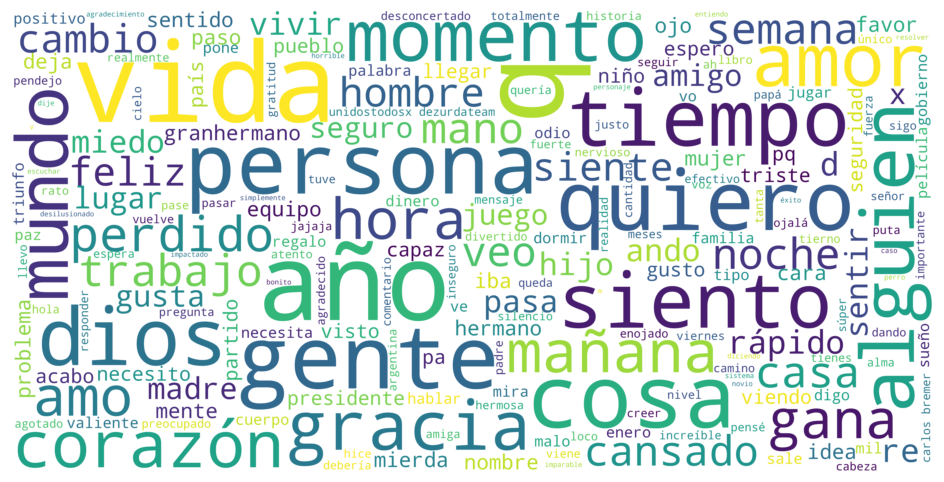

In [74]:
wordcloud = WordCloud(
    max_font_size=100,
    background_color="white",
    scale=10,
    width=800,
    height=400
).generate(' '.join(words_clean))

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Conclusiones del análisis exploratorio

**Observaciones:**

- No exiten campos con nulos.
- Existen tweets (items en **text**) duplicados.
- El feature **emotion** es más específico que **sentiment**. Para el objetivo del proyecto se utilizará **sentiment**, agrupando en sentimientos "positivos" *("peaceful", "powerful", "joyful")* y "negativos" *("scared", "sad", "mad")*. Dichos agrupamientos mantienen una representatividad equilibrada de las categorías, con muestreos de 1.430 y 1.160 tweets respectivamente.
- Se observa diversidad en el campo **user**, sin predominio de ningún usuario.
- En el campo **text** se observa que existen emojis, nombres de usuarios (@usuario), hashtags, y formatos heterogéneos (ej. listas, enumeraciones, entrecomillados, etc)
- En el campo **text** se observan 2 registros con longitud excesiva

**Acciones requeridas sobre el corpus:**
- Eliminar tweets duplicados
- Eliminar tweets con longitud mayor excesiva
- Eliminar stopwords, signos de puntuación y espaciados de inicio/final, así como tokens vacíos
- Eliminar tags de usuarios en los mensajes (usuarios arrobados). Los hashtags y los emojis se recomienda conservarlos ya que pueden cumplir función de expresar ideas/sentimientos.
- Eliminar URLs
- Crear feature derivada de *sentimiento* que agrupe en polarización positivo/negativo
- Eliminar columnas *user*, *date*, *emotion*, *sentiment*

# Preprocesamiento del Texto

## Recarga del dataset

In [80]:
df = pd.read_csv(file)
df.shape

(2590, 5)

## Limpieza y estandarización

### Limpieza básica

#### Eliminación de tweets duplicados

In [81]:
df.drop_duplicates(subset=['text'], inplace=True)
df.shape

(2191, 5)

#### Remoción de tweets extremadamente largos

In [77]:
q1_len, q3_len = np.quantile(df['text'].map(len), [.25, .75])
iqr_len = q3_len - q1_len
outlier_high_limit_len = q3_len + (3 * iqr_len)
outlier_high_limit_len

621.0

In [79]:
df = df[df['text'].map(len)<(outlier_high_limit_len)]
df.shape

(2189, 5)

#### Agrupamiento polarizado de feature *sentiments*

In [82]:
POSITIVE_SENTIMENTS = ['peaceful', 'powerful', 'joyful']
#NEGATIVE_SENTIMENTS = ['scared', 'mad', 'sad']

df['positive_sentiment'] = df['sentiment'].map(lambda x: True if x in POSITIVE_SENTIMENTS else False)

#### Eliminación de columnas superfluas

In [83]:
df.drop(columns=['user', 'date', 'emotion', 'sentiment'], inplace=True)
df.shape

(2191, 2)

#### Eliminación de nombres de usuarios en feature *text*

In [84]:
df['text'] = df['text'].map(lambda x: re.sub(r'@\w+', '', x))

#### Eliminación de URLs en feature *text*

In [85]:
df['text'] = df['text'].map(lambda x: re.sub(r'\b(?:http|https|www)\S*', '', x))

#### Conversión a todo minúsculas

In [86]:
df['text'] = df['text'].map(str.lower)

## Procesamiento NLP con spaCy

In [87]:
nlp = es_core_news_md.load()

### Tokenización

In [88]:
df['text_tokens'] = df['text'].map(nlp)
df['text_tokens']

0             (termine, bien, abrumado, después, de, hoy)
1                                  (me, siento, abrumado)
2       (me, siento, un, poco, abrumado, por, la, cant...
3       (salvador, la, única, persona, que, no, la, ha...
4       (denme, un, helado, o, algo, que, ando, full, ...
                              ...                        
2584       (debes, amar, sin, miedo, a, ser, traicionado)
2585    (no, podemos, vivir, con, miedo, :,   , ¡, man...
2586    (la, vida, es, un, constante, ,, sin, miedo, a...
2587    (esquizofrenia, =, mente, dividida, :, miedo, ...
2588    (", lo, que, más, miedo, me, da, ,, es, ver, c...
Name: text_tokens, Length: 2191, dtype: object

### Eliminación de stopwords y signos de puntuación

In [92]:
def clear_sw_punct(doc: spacy.tokens.doc.Doc) -> spacy.tokens.doc.Doc:
    """
    Eliminación de tokens identificados por spaCy como stopwords, signos de
    puntuación espacios o símbolos.
    """
    doc = [token for token in doc if
           not token.is_stop and
           not token.is_punct and
           not token.is_space and
           token.pos_ != 'SYM'
          ]
    return doc

In [93]:
df['text_tokens'] = df['text_tokens'].map(clear_sw_punct)

### Lematización

In [94]:
def lematizer(doc: spacy.tokens.doc.Doc) -> list:
    doc = [token.lemma_ for token in doc]
    return doc

In [95]:
df['text_tokens'] = df['text_tokens'].map(lematizer)

### Visualización de Palabras con Word Cloud por tipo de sentimiento

In [98]:
positive_words = ' '.join(df[df['positive_sentiment'] == True]['text_tokens'].map(' '.join).to_list())
negative_words = ' '.join(df[df['positive_sentiment'] == False]['text_tokens'].map(' '.join).to_list())

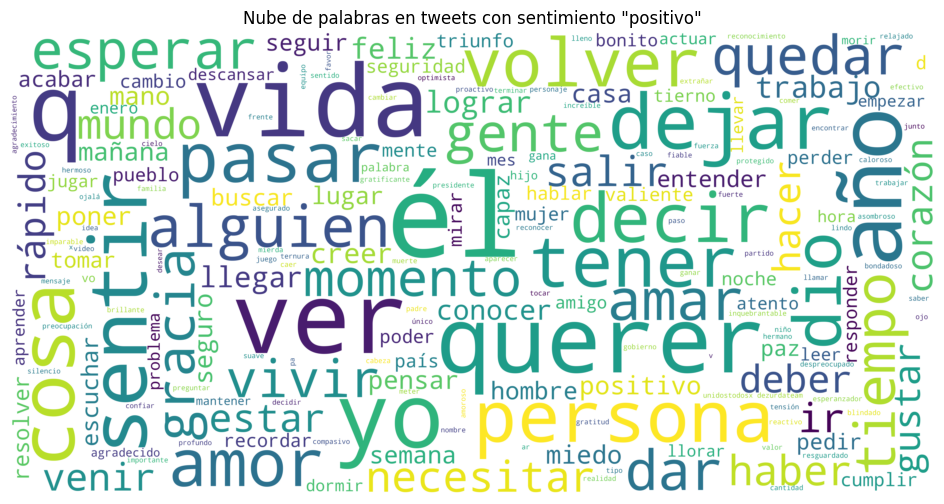

In [99]:
wordcloud = WordCloud(
    max_font_size=100,
    background_color="white",
    scale=10,
    width=800,
    height=400
).generate(positive_words)

plt.figure(figsize=(12,6))
plt.title('Nube de palabras en tweets con sentimiento "positivo"')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

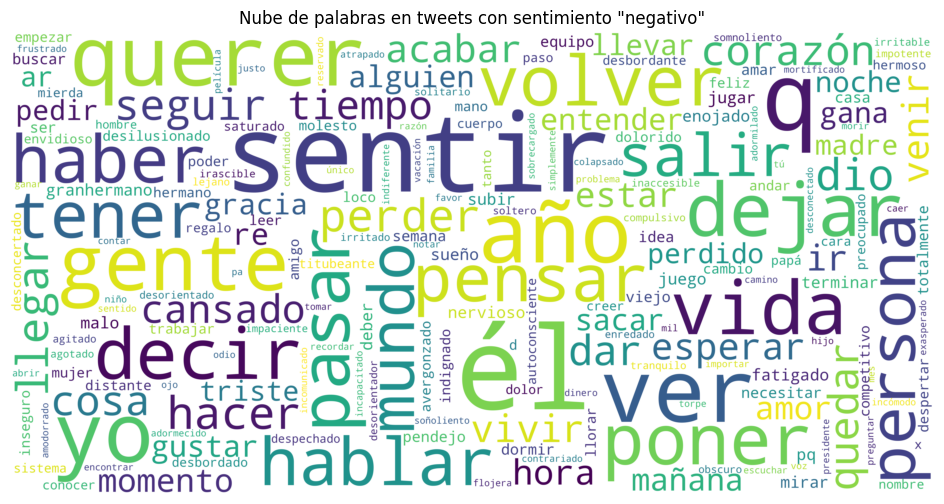

In [100]:
wordcloud = WordCloud(
    max_font_size=100,
    background_color="white",
    scale=10,
    width=800,
    height=400
).generate(negative_words)

plt.figure(figsize=(12,6))
plt.title('Nube de palabras en tweets con sentimiento "negativo"')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [101]:
df_token = df.drop(columns='text')
df_token['text_tokens'] = df_token['text_tokens'].map(' '.join)

In [102]:
df_token

,positive_sentiment,text_tokens
0,False,terminar abrumar
1,False,sentir abrumado
2,False,sentir abrumado cantidad cosa querer dibujar j...
3,False,salvador único persona abrumar versión ❤ 😒 ❤ n...
4,False,denmar helado ar full abrumado
...,...,...
2584,True,deber amar miedo traicionar
2585,True,vivir miedo manejen borracho dejen cinturón se...
2586,True,vida constante miedo éxito 💅 🏼
2587,True,esquizofrenia = mente dividido miedo realidad ...


### Vectorización TF-IDF

In [103]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_tweets = tfidf_vectorizer.fit_transform(df_token['text_tokens'])

# Modelo

### Librerias necesarias para implementar los modelos

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

### División de datos en conjuntos de entrenamiento y prueba

In [105]:
X = tfidf_matrix_tweets
y = df_token['positive_sentiment']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Creación de modelo

In [107]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

### Predicción con conjunto de prueba

In [108]:
y_hat_test = lr_model.predict(X_test)

### Evaluación del rendimiento del modelo

In [109]:
print("F1 score: ", f1_score(y_test, y_hat_test))
print("Accuracy: ", accuracy_score(y_test, y_hat_test)*100)

F1 score:  0.8476357267950964
Accuracy:  80.18223234624145


### Optimización de modelo

In [110]:
lr_model = LogisticRegression(penalty='l1', C=10, solver='liblinear')
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(C=10, penalty='l1', solver='liblinear')

In [111]:
y_hat_test = lr_model.predict(X_test)

In [112]:
print("F1 score: ", f1_score(y_test, y_hat_test))
print("Accuracy: ", accuracy_score(y_test, y_hat_test)*100)

F1 score:  0.9346153846153847
Accuracy:  92.25512528473804


# Conclusiones

Con un modelo simple se obtuvieron resultados aceptables.
Como investigación futura se buscará desarrollar comparativas con otros tipos de modelos, incluyendo una clasificación multiclase que permita aumentar la especificidad en la clasificación del sentimiento para explotar la alta calidad de etiquetado del dataset.